In [1]:
# Regresión Ponderada Geográficamente Multiescala (MGWR)

import os
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import box
from rasterstats import zonal_stats
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler

ruta_geoformas = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Inventario_geoformas_karsticas_Dunita.shp"
ruta_contorno  = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Contorno_Dunita.shp"
ruta_dem       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\dem_clip.tif"
ruta_slope     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\pendiente.tif"
ruta_twi       = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\Raster\TWI.tif"
ruta_cover     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Cobertura_final.shp"
ruta_drain     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Drenajes_clip_POT_final.shp"
ruta_fault     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\SIG\SHP\Fallas_lineam.shp"

gdf_points  = gpd.read_file(ruta_geoformas)
gdf_contour = gpd.read_file(ruta_contorno)

# Generar cuadrícula de 100x100 metros
cell_size = 100
minx, miny, maxx, maxy = gdf_contour.total_bounds
xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)
polygons = [box(x, y, x+cell_size, y+cell_size) for x in xs for y in ys]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf_contour.crs)
grid = gpd.clip(grid, gdf_contour)

# Conteo de puntos (variable dependiente)
join = gpd.sjoin(grid, gdf_points, how='left', predicate='intersects')
counts = join.groupby(join.index).size()
grid['count'] = counts.reindex(grid.index).fillna(0).astype(int)

# Extraer estadísticas zonales de los rasters
grid['dem_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_dem,   stats=['mean'], nodata=-9999)]
grid['slope_mean'] = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_slope, stats=['mean'], nodata=-9999)]
grid['twi_mean']   = [s['mean'] if s and s['mean'] is not None else np.nan for s in zonal_stats(grid, ruta_twi,   stats=['mean'], nodata=-9999)]

# Cobertura y calcular distancias
cov_gdf  = gpd.read_file(ruta_cover)[['d_N3_COBER','geometry']].to_crs(grid.crs)
centroids= grid.copy()
centroids['geometry'] = centroids.centroid
cov_join = gpd.sjoin(centroids, cov_gdf, how='left', predicate='within')
grid['cover'] = cov_join['d_N3_COBER'].fillna('None')

drains = gpd.read_file(ruta_drain).to_crs(grid.crs)
faults = gpd.read_file(ruta_fault).to_crs(grid.crs)

union_drains = drains.geometry.union_all()
union_faults = faults.geometry.union_all()

grid['dist_drain'] = centroids.geometry.distance(union_drains)
grid['dist_fault'] = centroids.geometry.distance(union_faults)

# Limpiar datos: eliminar filas con valores nulos y crear el GDF final
df_mgwr = grid.dropna().copy()

# Preparación de variables y matrices para el modelo MGWR 

# Variables continuas
vars_continuas = ['dem_mean', 'slope_mean', 'twi_mean', 'dist_drain', 'dist_fault']

# Variables categóricas significativas 
coberturas_seleccionadas = [
    'Bosque fragmentado',
    'Mosaico de cultivos y espacios naturales'
]
vars_coberturas = ['cov_Bosque fragmentado', 'cov_Mosaico de cultivos y espacios naturales']

# Crear variables dummy solo para las coberturas seleccionadas
dummies = pd.get_dummies(df_mgwr['cover'], prefix='cov')
dummies_filtradas = dummies[vars_coberturas]
df_mgwr = df_mgwr.join(dummies_filtradas)

# Lista final de variables explicativas (X)
X_vars = vars_continuas + vars_coberturas

# Crear matrices y vectores
y = df_mgwr['count'].values.reshape((-1, 1))
X = df_mgwr[X_vars].values
coords = np.column_stack([df_mgwr.geometry.centroid.x, df_mgwr.geometry.centroid.y])

# Escalar (normalizar) las variables independientes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Búsqueda de Ancho de Banda (Bandwidth) y ajuste del modelo 

# Selector de ancho de banda (backfitting)
# multi=True indica que se buscará un ancho de banda para cada variable
bw_selector = Sel_BW(
    coords, y, X_scaled,
    multi=True,
    kernel='bisquare', # Kernel adaptativo de tipo bi-cuadrado
    fixed=False
)

bw_optimos = bw_selector.search()

# Ajustar el modelo MGWR usando los anchos de banda encontrados

mgwr_model = MGWR(
    coords, y, X_scaled,
    selector=bw_selector,
    kernel='bisquare',
    fixed=False
).fit()

print(mgwr_model.summary())

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                2426
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6850.277
Log-likelihood:                                                   -4701.494
AIC:                                                               9418.988
AICc:                                                              9421.062
BIC:                                                             -11995.612
R2:                                                                   0.106
Adj. R2:                                                              0.103

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

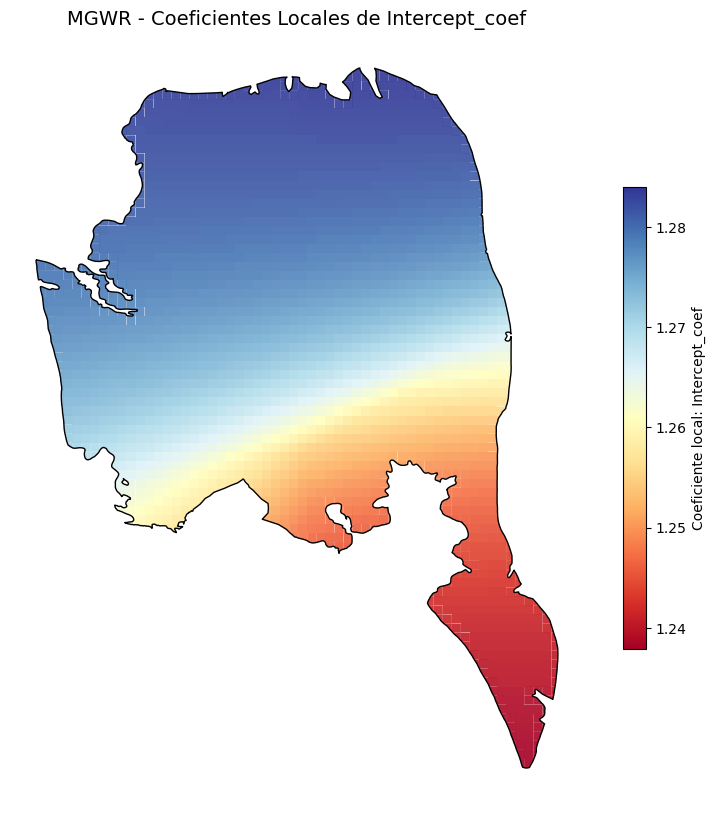

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\Intercept_coef_coef_map.png


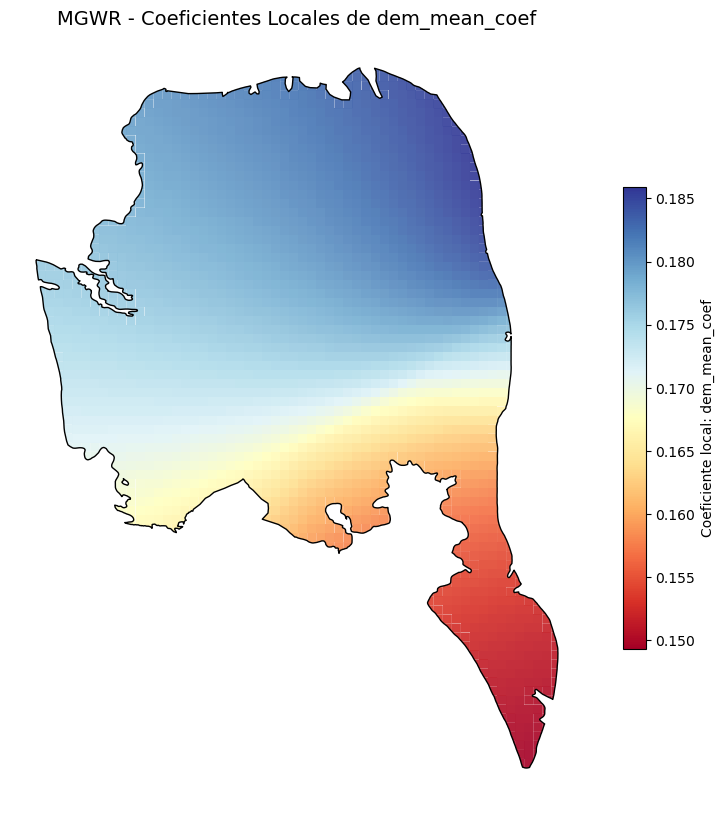

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\dem_mean_coef_coef_map.png


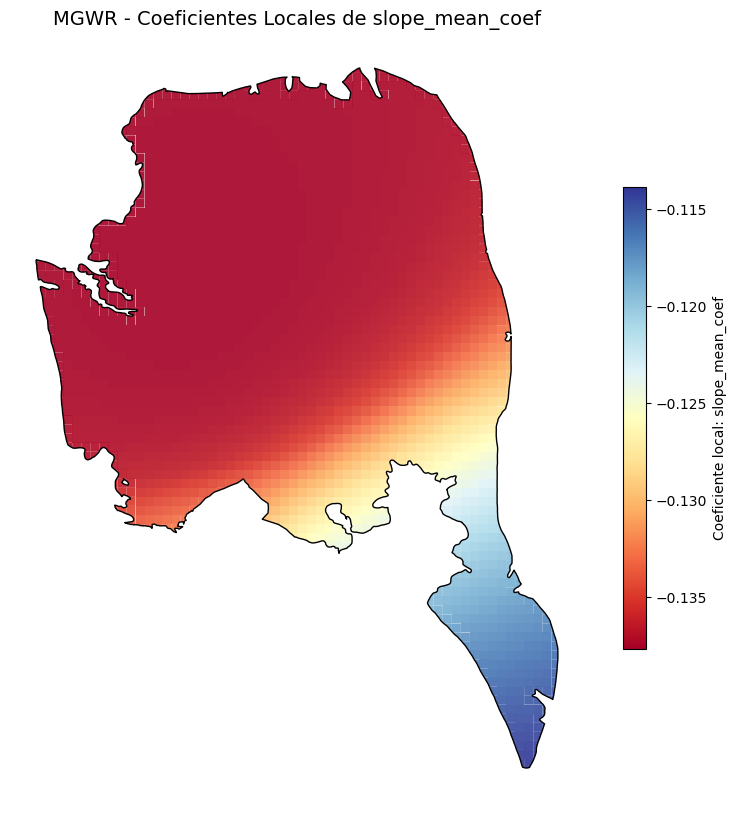

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\slope_mean_coef_coef_map.png


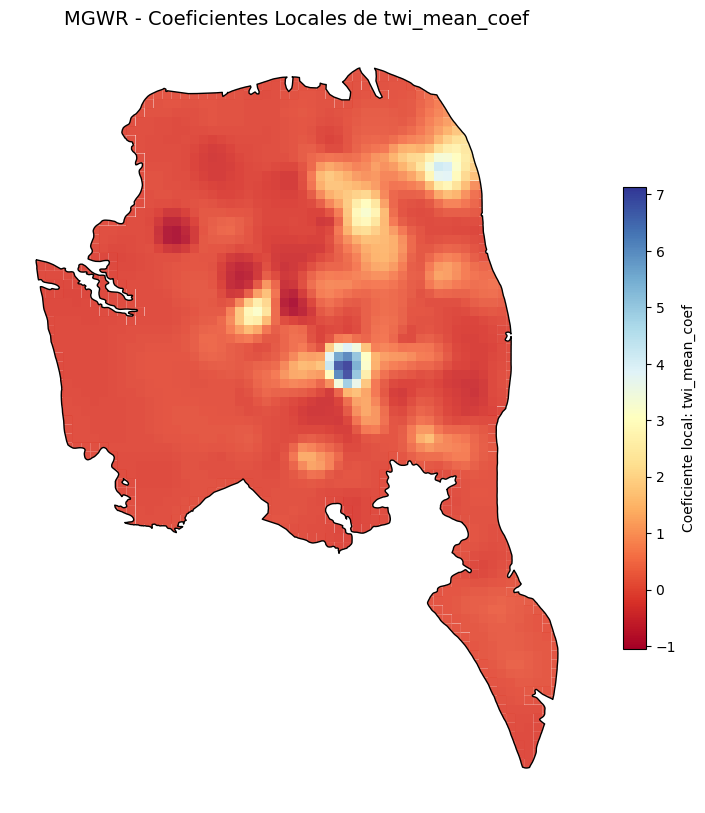

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\twi_mean_coef_coef_map.png


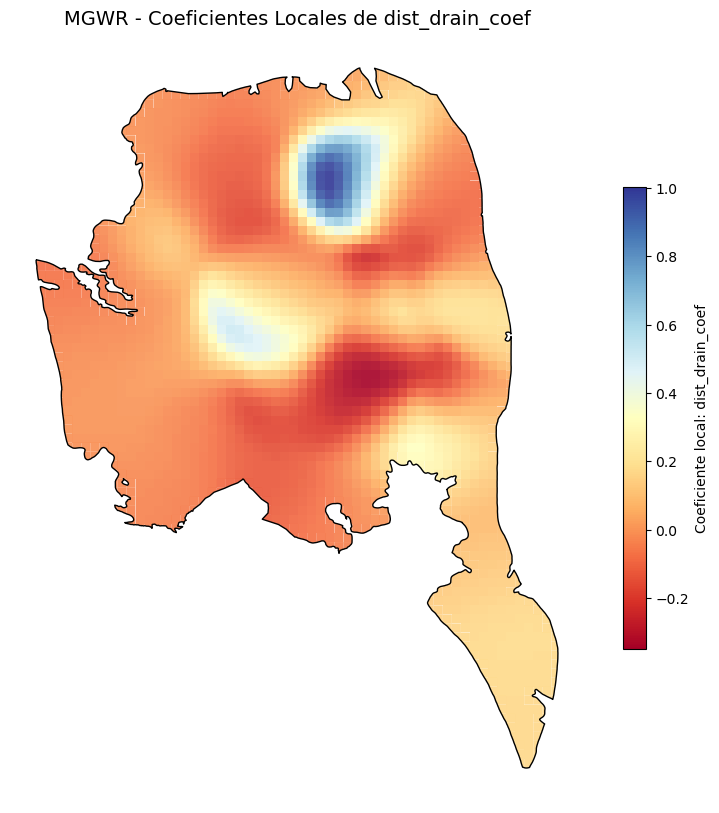

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\dist_drain_coef_coef_map.png


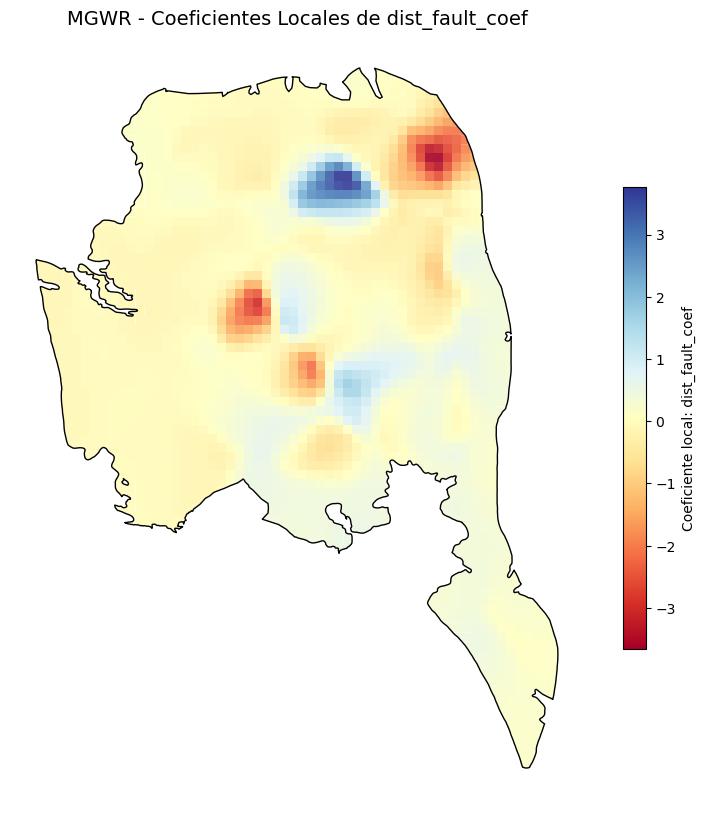

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\dist_fault_coef_coef_map.png


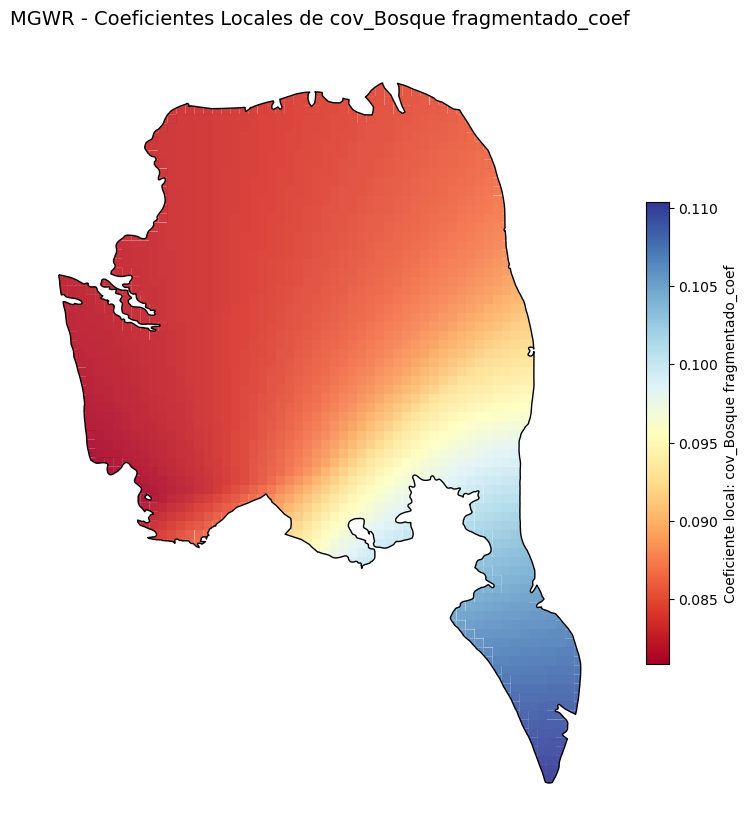

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\cov_Bosque fragmentado_coef_coef_map.png


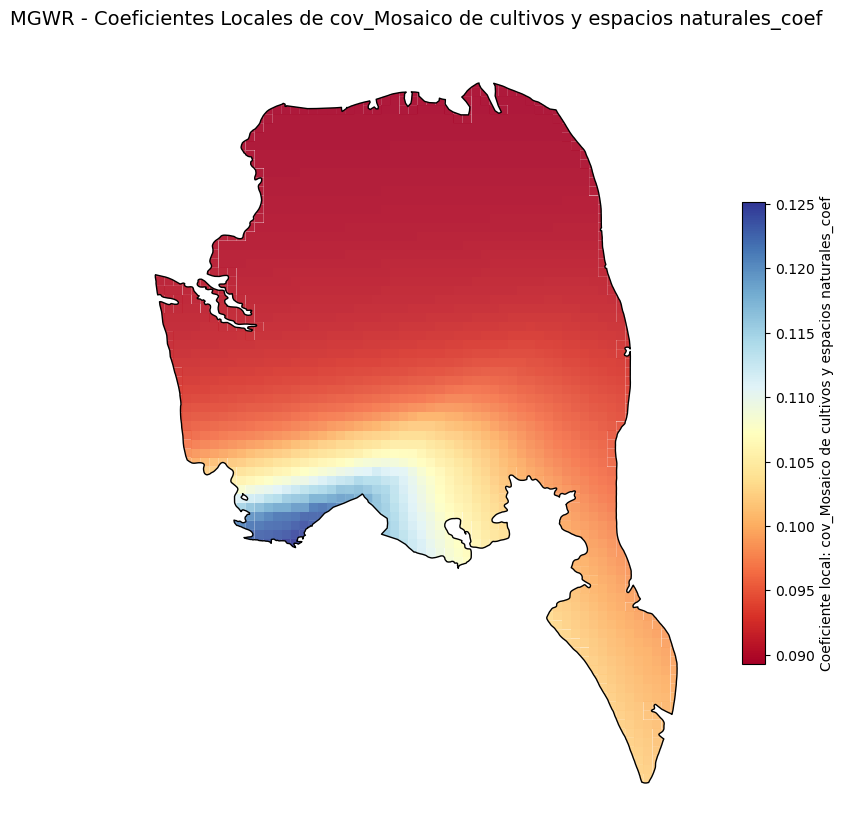

Mapa guardado: C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG\MGWR_coef_maps\cov_Mosaico de cultivos y espacios naturales_coef_coef_map.png


In [3]:
# Mapas de todos los coeficientes locales del modelo MGWR

import matplotlib.pyplot as plt
import geopandas as gpd
import os
import pandas as pd

# Nombres de las variables 
var_names = [
    'Intercept', 'dem_mean', 'slope_mean', 'twi_mean',
    'dist_drain', 'dist_fault',
    'cov_Bosque fragmentado',
    'cov_Mosaico de cultivos y espacios naturales'
]

# Crear DataFrame con sufijo _coef para los coeficientes
coef_columns = [f"{v}_coef" for v in var_names]
coef_df = pd.DataFrame(mgwr_model.params, columns=coef_columns, index=df_mgwr.index)

# Unir coeficientes al GeoDataFrame, evitando duplicados
for col in coef_df.columns:
    if col not in df_mgwr.columns:
        df_mgwr[col] = coef_df[col]

# Crear carpeta de salida 
output_dir     = r"C:\Users\esteb\Desktop\GEOS\Maestría\2025-1S\Análisis geoespacial\Propuesta_geoformas\PNG"
output_dir_maps = os.path.join(output_dir, 'MGWR_coef_maps')
os.makedirs(output_dir_maps, exist_ok=True)

# Función para mapear coeficientes locales 
def plot_coef_map(df, column, gdf_contour=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    df.plot(
        column=column,
        cmap='RdYlBu',
        legend=True,
        edgecolor='none',     # ← Elimina la malla entre celdas
        linewidth=0,
        ax=ax,
        alpha=0.9,
        legend_kwds={
            'label': f'Coeficiente local: {column}',
            'shrink': 0.6
        }
    )
    
    if gdf_contour is not None:
        gdf_contour.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    
    ax.set_title(f"MGWR - Coeficientes Locales de {column}", fontsize=14)
    ax.set_axis_off()
    
    output_path = os.path.join(output_dir_maps, f"{column}_coef_map.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Mapa guardado: {output_path}")

# Generar mapas para todos los coeficientes
for coef in coef_columns:
    plot_coef_map(df_mgwr, coef, gdf_contour=gdf_contour)
